In [1]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib notebook

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [98]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph

def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          metrics=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss',
                   'total_complexity',
                   'complexity_parts'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    
    X_train, X_val, y_train, y_val = dataset
    visualizer = Visualizer(num_epochs, nn.num_cascades, watches=watches)
    train_metrics = [None] * len(metrics)
    val_metrics = [None] * len(metrics)
    
    for i in range(len(metrics)):
        if i == metrics.index('complexity_parts'):
            train_metrics[i] = [None] * nn.num_cascades
            val_metrics[i] = [None] * nn.num_cascades
            
            for j in range(nn.num_cascades):
                train_metrics[i][j] = []
                val_metrics[i][j] = []
        else:
            train_metrics[i] = []
            val_metrics[i] = []
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = [0] * len(metrics)
        train_measurements[metrics.index('complexity_parts')] = [0] * nn.num_cascades
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for i, metric in enumerate(nn.train(inputs, targets)):
                if i == metrics.index('complexity_parts'):
                    for j, complexity_part in enumerate(nn.estimate_complexity(inputs, targets)):
                        train_measurements[i][j] += complexity_part
                else:
                    train_measurements[i] += metric

            train_batches += 1
            
        for i, metric in enumerate(train_measurements):
            if i == metrics.index('complexity_parts'):
                for j, complexity_part in enumerate(metric):
                    train_metrics[i][j].append(complexity_part / train_batches)
            else:
                train_metrics[i].append(metric / train_batches)

        # And a full pass over the validation data:
        val_measurements = [0] * len(metrics)
        val_measurements[metrics.index('complexity_parts')] = [0] * nn.num_cascades
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for i, metric in enumerate(nn.evaluate(inputs, targets)):
                if i == metrics.index('complexity_parts'):
                    for j, complexity_part in enumerate(nn.estimate_complexity(inputs, targets)):
                        val_measurements[i][j] += complexity_part
                else:
                    val_measurements[i] += metric

            val_batches += 1
            
        for i, metric in enumerate(val_measurements):
            if i == metrics.index('complexity_parts'):
                for j, complexity_part in enumerate(metric):
                    val_metrics[i][j].append(complexity_part / train_batches)
            else:
                val_metrics[i].append(metric / val_batches)

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_metrics, val_metrics)
    
    visualizer.finish()

In [4]:
dataset = np.load('../data/X.npy')
targets = np.load('../data/targets.npy')

In [5]:
X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       targets.reshape(-1, 1, 200, 200).astype(np.float32))

# Phase 1

In [83]:
network = CascadeBase(img_shape=(200, 200),
                      c=1.0,
                      c_complexity=0,
                      c_sub_objs=[1e-4, 1e-3],
                      c_sub_obj_cs=[1e-3, 1e-2],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

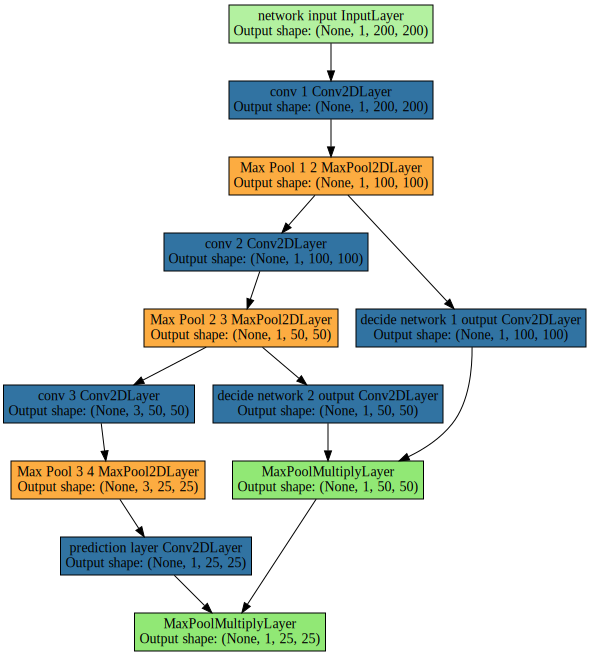

In [7]:
with open('../images/net.svg', 'w') as f:
    g = make_pydot_graph(lasagne.layers.get_all_layers(network.masked_output_layer))
    f.write(g.create_svg(f='svg'))

display(SVG(filename='../images/net.svg'))

In [100]:
learn(network,
      X_y,
      num_epochs=100,
      batch_size=50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1 of 100 took 19.594s


NameError: global name 'lines1' is not defined

In [23]:
network.save('../weights', 'main_loss_no_mul')

In [26]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[0],
                      mul = True)

<IPython.core.display.Javascript object>


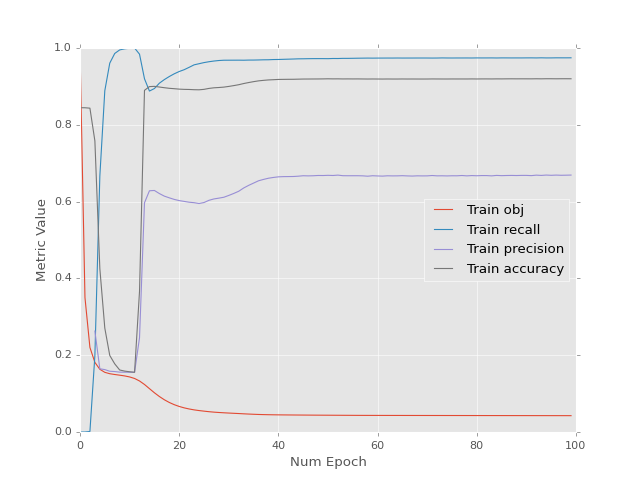

<IPython.core.display.Javascript object>


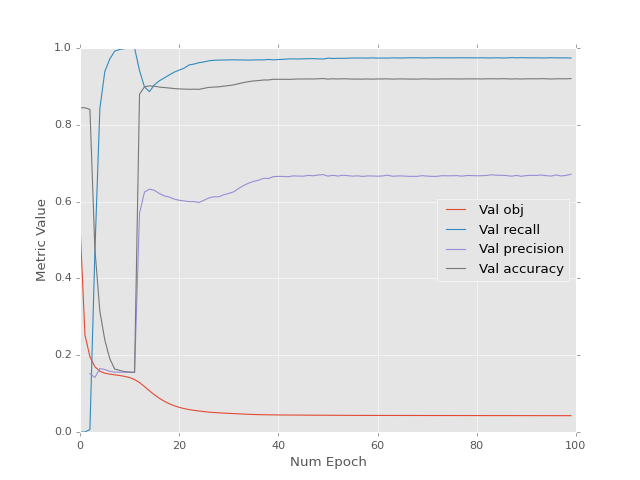

Epoch 1 of 100 took 6.701s
Epoch 2 of 100 took 6.537s
Epoch 3 of 100 took 6.867s
Epoch 4 of 100 took 6.594s
Epoch 5 of 100 took 6.554s
Epoch 6 of 100 took 6.580s
Epoch 7 of 100 took 6.702s
Epoch 8 of 100 took 6.520s
Epoch 9 of 100 took 6.549s
Epoch 10 of 100 took 6.521s
Epoch 11 of 100 took 6.585s
Epoch 12 of 100 took 6.735s
Epoch 13 of 100 took 6.525s
Epoch 14 of 100 took 6.603s
Epoch 15 of 100 took 6.547s
Epoch 16 of 100 took 6.525s
Epoch 17 of 100 took 6.513s
Epoch 18 of 100 took 7.046s
Epoch 19 of 100 took 7.185s
Epoch 20 of 100 took 7.126s
Epoch 21 of 100 took 6.555s
Epoch 22 of 100 took 6.534s
Epoch 23 of 100 took 6.537s
Epoch 24 of 100 took 6.716s
Epoch 25 of 100 took 6.529s
Epoch 26 of 100 took 6.543s
Epoch 27 of 100 took 6.600s
Epoch 28 of 100 took 6.612s
Epoch 29 of 100 took 6.552s
Epoch 30 of 100 took 6.566s
Epoch 31 of 100 took 6.589s
Epoch 32 of 100 took 6.874s
Epoch 33 of 100 took 6.549s
Epoch 34 of 100 took 6.560s
Epoch 35 of 100 took 6.511s
Epoch 36 of 100 took 6.728s
E

In [27]:
learn(network, X_y, num_epochs=100, batch_size=50)

In [30]:
network.save('../weights', 'main_loss_mul')

In [18]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-3],
                      c_sub_obj_cs=[1e-1],
                      mul = False)

<IPython.core.display.Javascript object>


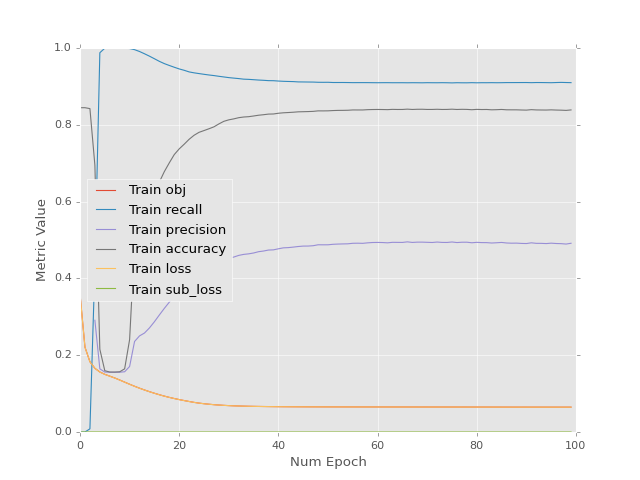

<IPython.core.display.Javascript object>


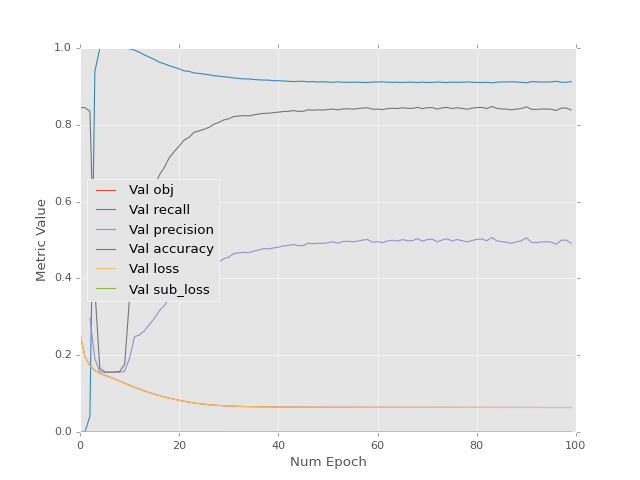

Epoch 1 of 100 took 6.909s
Epoch 2 of 100 took 7.749s
Epoch 3 of 100 took 7.046s
Epoch 4 of 100 took 7.011s
Epoch 5 of 100 took 6.906s
Epoch 6 of 100 took 6.662s
Epoch 7 of 100 took 6.842s
Epoch 8 of 100 took 6.990s
Epoch 9 of 100 took 6.699s
Epoch 10 of 100 took 6.695s
Epoch 11 of 100 took 6.668s
Epoch 12 of 100 took 6.995s
Epoch 13 of 100 took 6.795s
Epoch 14 of 100 took 6.948s
Epoch 15 of 100 took 6.906s
Epoch 16 of 100 took 6.656s
Epoch 17 of 100 took 7.141s
Epoch 18 of 100 took 7.372s
Epoch 19 of 100 took 7.267s
Epoch 20 of 100 took 6.790s
Epoch 21 of 100 took 6.710s
Epoch 22 of 100 took 7.133s
Epoch 23 of 100 took 7.317s
Epoch 24 of 100 took 7.000s
Epoch 25 of 100 took 7.172s
Epoch 26 of 100 took 7.110s
Epoch 27 of 100 took 7.022s
Epoch 28 of 100 took 6.762s
Epoch 29 of 100 took 6.777s
Epoch 30 of 100 took 6.788s
Epoch 31 of 100 took 6.699s
Epoch 32 of 100 took 6.666s
Epoch 33 of 100 took 7.327s
Epoch 34 of 100 took 7.349s
Epoch 35 of 100 took 7.063s
Epoch 36 of 100 took 6.719s
E

In [19]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss'])

In [20]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-1],
                      c_sub_obj_cs=[1e-1],
                      mul = False)

<IPython.core.display.Javascript object>


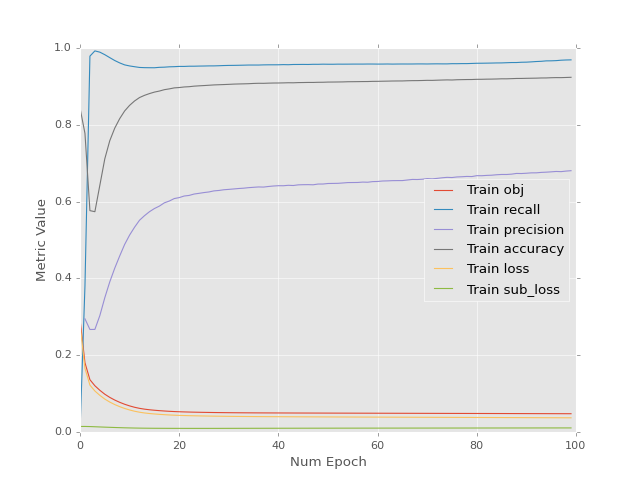

<IPython.core.display.Javascript object>


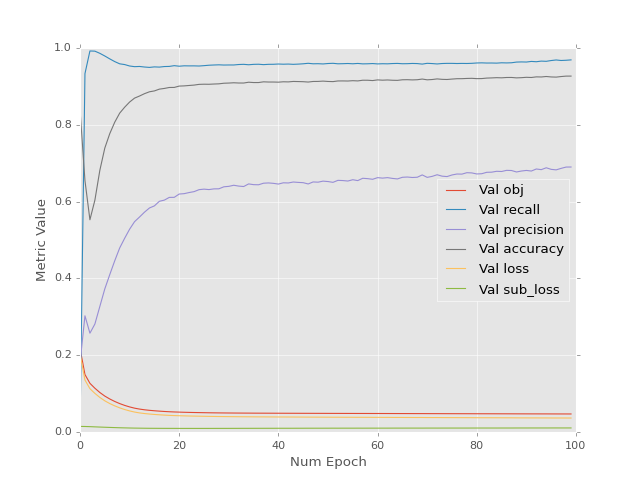

Epoch 1 of 100 took 6.696s
Epoch 2 of 100 took 6.570s
Epoch 3 of 100 took 7.063s
Epoch 4 of 100 took 6.558s
Epoch 5 of 100 took 6.577s
Epoch 6 of 100 took 6.635s
Epoch 7 of 100 took 6.653s
Epoch 8 of 100 took 6.669s
Epoch 9 of 100 took 6.619s
Epoch 10 of 100 took 6.852s
Epoch 11 of 100 took 6.669s
Epoch 12 of 100 took 6.695s
Epoch 13 of 100 took 6.846s
Epoch 14 of 100 took 6.686s
Epoch 15 of 100 took 6.694s
Epoch 16 of 100 took 6.875s
Epoch 17 of 100 took 6.687s
Epoch 18 of 100 took 6.681s
Epoch 19 of 100 took 6.666s
Epoch 20 of 100 took 6.707s
Epoch 21 of 100 took 7.038s
Epoch 22 of 100 took 7.021s
Epoch 23 of 100 took 6.889s
Epoch 24 of 100 took 6.653s
Epoch 25 of 100 took 6.679s
Epoch 26 of 100 took 6.767s
Epoch 27 of 100 took 6.908s
Epoch 28 of 100 took 6.793s
Epoch 29 of 100 took 6.867s
Epoch 30 of 100 took 6.745s
Epoch 31 of 100 took 6.854s
Epoch 32 of 100 took 7.107s
Epoch 33 of 100 took 6.676s
Epoch 34 of 100 took 6.760s
Epoch 35 of 100 took 7.033s
Epoch 36 of 100 took 6.681s
E

In [21]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss'])

In [22]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-1],
                      c_sub_obj_cs=[1e-2],
                      mul = False)

<IPython.core.display.Javascript object>


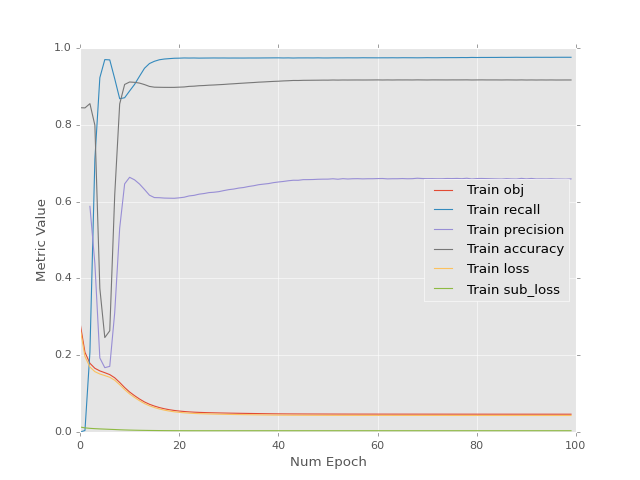

<IPython.core.display.Javascript object>


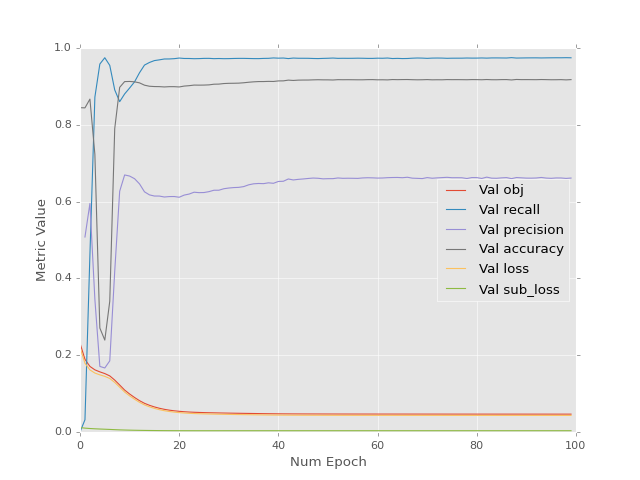

Epoch 1 of 100 took 6.880s
Epoch 2 of 100 took 6.570s
Epoch 3 of 100 took 6.846s
Epoch 4 of 100 took 6.980s
Epoch 5 of 100 took 6.687s
Epoch 6 of 100 took 6.554s
Epoch 7 of 100 took 6.591s
Epoch 8 of 100 took 6.743s
Epoch 9 of 100 took 6.643s
Epoch 10 of 100 took 6.704s
Epoch 11 of 100 took 6.670s
Epoch 12 of 100 took 6.658s
Epoch 13 of 100 took 6.963s
Epoch 14 of 100 took 6.889s
Epoch 15 of 100 took 6.961s
Epoch 16 of 100 took 6.692s
Epoch 17 of 100 took 6.895s
Epoch 18 of 100 took 6.672s
Epoch 19 of 100 took 6.860s
Epoch 20 of 100 took 6.659s
Epoch 21 of 100 took 6.901s
Epoch 22 of 100 took 6.764s
Epoch 23 of 100 took 6.784s
Epoch 24 of 100 took 7.117s
Epoch 25 of 100 took 6.917s
Epoch 26 of 100 took 6.870s
Epoch 27 of 100 took 7.556s
Epoch 28 of 100 took 7.118s
Epoch 29 of 100 took 6.983s
Epoch 30 of 100 took 6.748s
Epoch 31 of 100 took 6.674s
Epoch 32 of 100 took 6.996s
Epoch 33 of 100 took 6.962s
Epoch 34 of 100 took 6.663s
Epoch 35 of 100 took 7.163s
Epoch 36 of 100 took 6.767s
E

In [23]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss'])

In [24]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1],
                      c_sub_obj_cs=[1e-2],
                      mul = False)

<IPython.core.display.Javascript object>


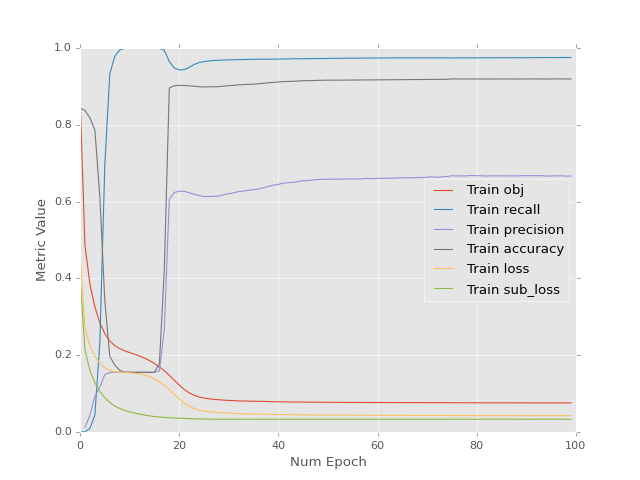

<IPython.core.display.Javascript object>


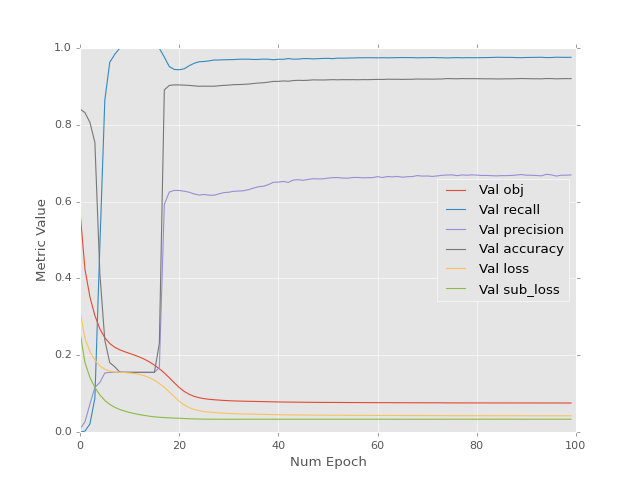

Epoch 1 of 100 took 6.740s
Epoch 2 of 100 took 6.660s
Epoch 3 of 100 took 6.772s
Epoch 4 of 100 took 6.676s
Epoch 5 of 100 took 6.772s
Epoch 6 of 100 took 6.611s
Epoch 7 of 100 took 6.649s
Epoch 8 of 100 took 6.842s
Epoch 9 of 100 took 6.623s
Epoch 10 of 100 took 6.823s
Epoch 11 of 100 took 6.789s
Epoch 12 of 100 took 6.656s
Epoch 13 of 100 took 6.856s
Epoch 14 of 100 took 6.684s
Epoch 15 of 100 took 6.645s
Epoch 16 of 100 took 6.664s
Epoch 17 of 100 took 6.680s
Epoch 18 of 100 took 6.649s
Epoch 19 of 100 took 6.676s
Epoch 20 of 100 took 6.671s
Epoch 21 of 100 took 6.651s
Epoch 22 of 100 took 6.675s
Epoch 23 of 100 took 6.668s
Epoch 24 of 100 took 6.654s
Epoch 25 of 100 took 6.680s
Epoch 26 of 100 took 6.672s
Epoch 27 of 100 took 6.862s
Epoch 28 of 100 took 6.698s
Epoch 29 of 100 took 6.641s
Epoch 30 of 100 took 6.995s
Epoch 31 of 100 took 7.273s
Epoch 32 of 100 took 7.008s
Epoch 33 of 100 took 6.703s
Epoch 34 of 100 took 6.949s
Epoch 35 of 100 took 7.113s
Epoch 36 of 100 took 6.896s
E

In [25]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss'])

In [26]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-1],
                      c_sub_obj_cs=[1e-2],
                      mul = True)

<IPython.core.display.Javascript object>


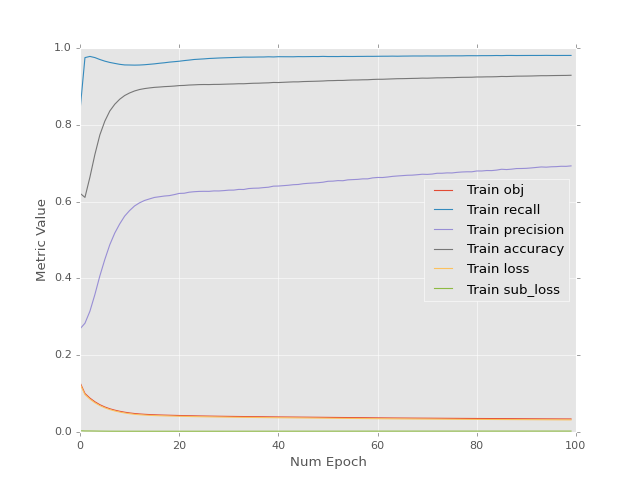

<IPython.core.display.Javascript object>


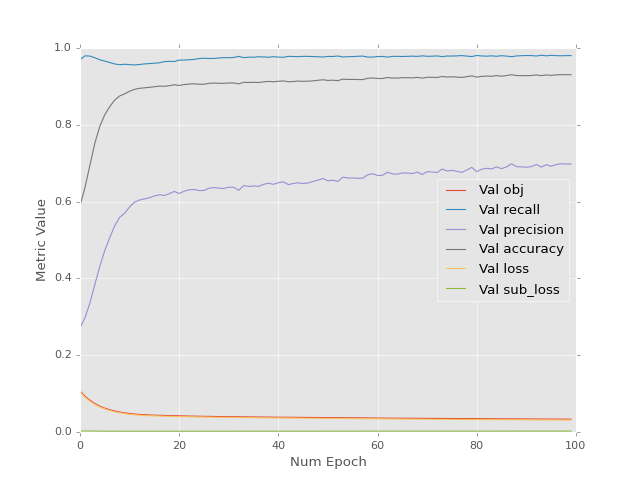

Epoch 1 of 100 took 7.139s
Epoch 2 of 100 took 6.648s
Epoch 3 of 100 took 6.704s
Epoch 4 of 100 took 6.563s
Epoch 5 of 100 took 6.820s
Epoch 6 of 100 took 6.575s
Epoch 7 of 100 took 7.248s
Epoch 8 of 100 took 7.362s
Epoch 9 of 100 took 7.206s
Epoch 10 of 100 took 7.038s
Epoch 11 of 100 took 6.739s
Epoch 12 of 100 took 6.744s
Epoch 13 of 100 took 6.733s
Epoch 14 of 100 took 6.757s
Epoch 15 of 100 took 6.993s
Epoch 16 of 100 took 6.830s
Epoch 17 of 100 took 6.659s
Epoch 18 of 100 took 7.189s
Epoch 19 of 100 took 7.391s
Epoch 20 of 100 took 6.689s
Epoch 21 of 100 took 6.694s
Epoch 22 of 100 took 6.828s
Epoch 23 of 100 took 6.678s
Epoch 24 of 100 took 6.714s
Epoch 25 of 100 took 6.664s
Epoch 26 of 100 took 6.846s
Epoch 27 of 100 took 6.714s
Epoch 28 of 100 took 6.627s
Epoch 29 of 100 took 6.683s
Epoch 30 of 100 took 6.714s
Epoch 31 of 100 took 7.202s
Epoch 32 of 100 took 7.220s
Epoch 33 of 100 took 6.690s
Epoch 34 of 100 took 6.663s
Epoch 35 of 100 took 6.794s
Epoch 36 of 100 took 6.677s
E

In [27]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss'])

In [30]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-3],
                      c_sub_obj_cs=[1e-2],
                      mul = True)

<IPython.core.display.Javascript object>


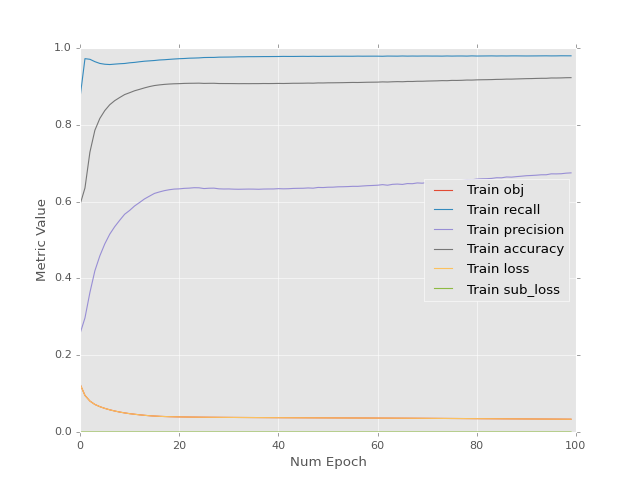

<IPython.core.display.Javascript object>


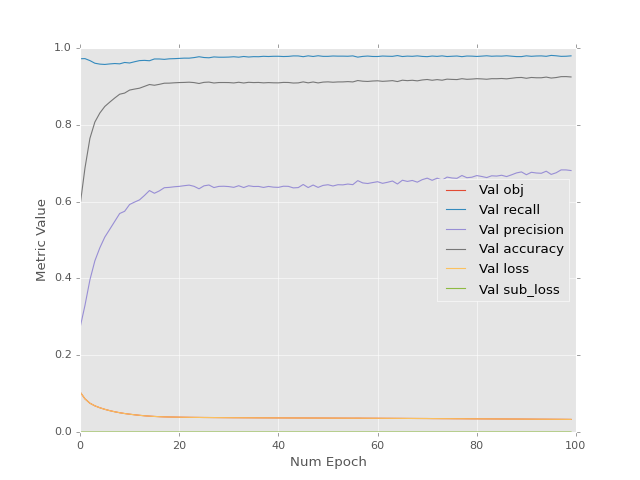

Epoch 1 of 100 took 7.103s
Epoch 2 of 100 took 6.686s
Epoch 3 of 100 took 7.027s
Epoch 4 of 100 took 6.693s
Epoch 5 of 100 took 6.681s
Epoch 6 of 100 took 6.827s
Epoch 7 of 100 took 6.738s
Epoch 8 of 100 took 6.882s
Epoch 9 of 100 took 6.926s
Epoch 10 of 100 took 7.058s
Epoch 11 of 100 took 6.906s
Epoch 12 of 100 took 6.710s
Epoch 13 of 100 took 6.899s
Epoch 14 of 100 took 6.695s
Epoch 15 of 100 took 6.789s
Epoch 16 of 100 took 7.088s
Epoch 17 of 100 took 6.769s
Epoch 18 of 100 took 6.657s
Epoch 19 of 100 took 6.813s
Epoch 20 of 100 took 6.826s
Epoch 21 of 100 took 6.669s
Epoch 22 of 100 took 6.692s
Epoch 23 of 100 took 7.029s
Epoch 24 of 100 took 6.738s
Epoch 25 of 100 took 6.692s
Epoch 26 of 100 took 6.710s
Epoch 27 of 100 took 6.661s
Epoch 28 of 100 took 6.795s
Epoch 29 of 100 took 6.723s
Epoch 30 of 100 took 6.635s
Epoch 31 of 100 took 6.697s
Epoch 32 of 100 took 6.832s
Epoch 33 of 100 took 6.824s
Epoch 34 of 100 took 6.717s
Epoch 35 of 100 took 7.120s
Epoch 36 of 100 took 6.770s
E

In [31]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'loss', 'sub_loss'])

In [17]:
network.save('../weights', 'los+sub_los+mul')

In [34]:
network.load('../weights', 'los+sub_los+mul')

# Phase 2

In [59]:
network = CascadeBase(img_shape=(200, 200),
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-1],
                      c_sub_obj_cs=[1e-1],
                      mul = True)
network.load('../weights', 'los+sub_los+mul')

<IPython.core.display.Javascript object>


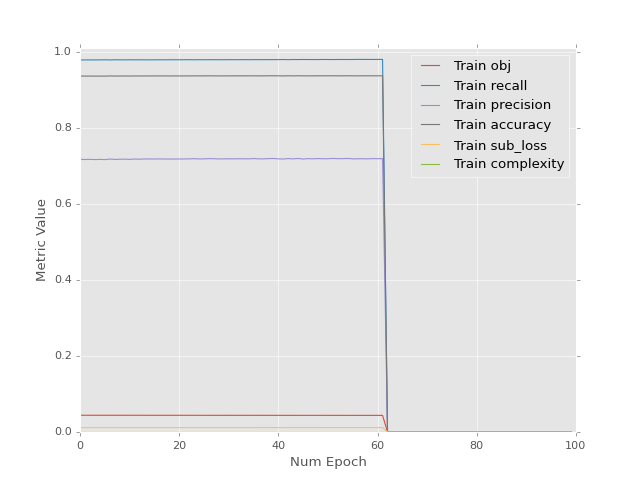

<IPython.core.display.Javascript object>


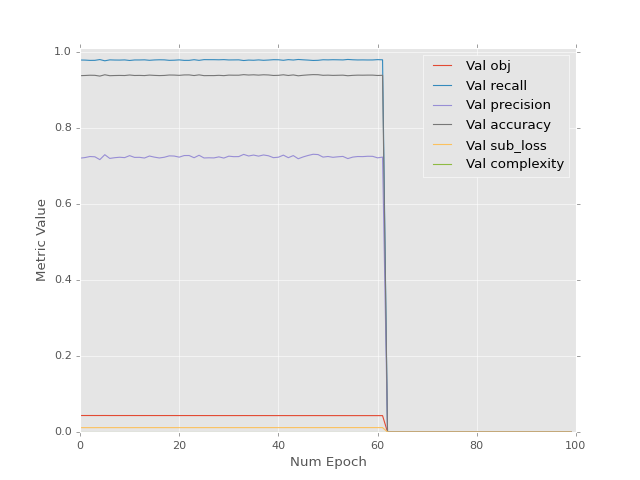

Epoch 1 of 100 took 7.798s
Epoch 2 of 100 took 6.660s
Epoch 3 of 100 took 6.686s
Epoch 4 of 100 took 6.603s
Epoch 5 of 100 took 6.880s
Epoch 6 of 100 took 6.692s
Epoch 7 of 100 took 6.590s
Epoch 8 of 100 took 6.980s
Epoch 9 of 100 took 6.745s
Epoch 10 of 100 took 6.629s
Epoch 11 of 100 took 6.690s
Epoch 12 of 100 took 7.341s
Epoch 13 of 100 took 7.020s
Epoch 14 of 100 took 6.776s
Epoch 15 of 100 took 6.785s
Epoch 16 of 100 took 7.356s
Epoch 17 of 100 took 6.979s
Epoch 18 of 100 took 6.953s
Epoch 19 of 100 took 6.885s
Epoch 20 of 100 took 6.794s
Epoch 21 of 100 took 7.078s
Epoch 22 of 100 took 6.951s
Epoch 23 of 100 took 6.982s
Epoch 24 of 100 took 7.073s
Epoch 25 of 100 took 6.970s
Epoch 26 of 100 took 6.940s
Epoch 27 of 100 took 6.755s
Epoch 28 of 100 took 6.737s
Epoch 29 of 100 took 6.932s
Epoch 30 of 100 took 6.812s
Epoch 31 of 100 took 6.771s
Epoch 32 of 100 took 6.718s
Epoch 33 of 100 took 6.884s
Epoch 34 of 100 took 6.717s
Epoch 35 of 100 took 7.033s
Epoch 36 of 100 took 7.402s
E

KeyboardInterrupt: 

In [61]:
learn(network, 
      X_y,
      num_epochs=100,
      batch_size=50,
      view=['obj', 'recall', 'precision', 'accuracy', 'sub_loss', 'complexity'])

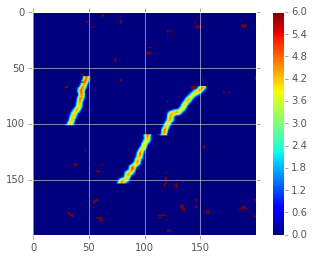

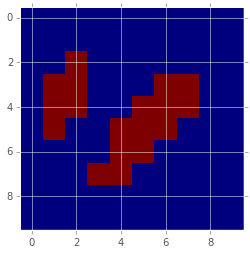

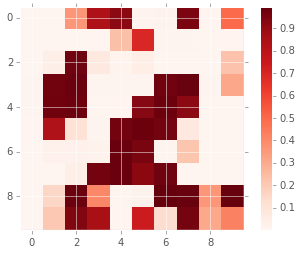

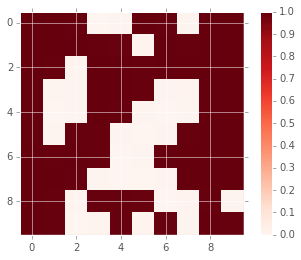

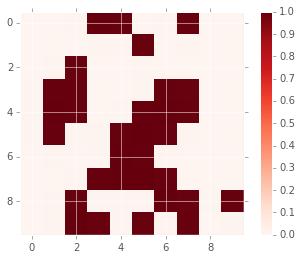

In [36]:
i = 2

plt.imshow(X_y[1][i].reshape((200, 200)))
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i].reshape((10, 10)), interpolation='none')
plt.show()

prediction = network.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

plt.imshow(prediction.reshape(10, 10), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

In [42]:
from models.cascade_base import CascadeBase

In [66]:
import lasagne

In [ ]:
lasagne.layers.get_all_layers()